This file plots out the results from Snakefile Run 2
(samples 8; methods: linreg, boosting, elastic, forest;
features: single, forest, string, string_hi, all)

Note the boosting had larger steps 0.1 and fewer n_estimators (200).
There are fewer alpha hyperparameter values to optimize for in ElasticNetCV
The results are output in a dictionary (model, metrics)

In [1]:
data_dir = '/Volumes/Ginkgo_Data/Data/2021-11_CPTACTrainedModels/out3'
out_dir = '01_ExportModelResults_Output/out3'
# out2 was the previous result that had duplicated tumor set 4 and did not ensure log read expression in all tables

In [2]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from predict_protein import download_cptac, select_features, train_model
from predict_protein import utils

get_dataframe = utils.get_dataframe

def get_median_corr(path):
    return np.median(get_dataframe(path)['corr_test'])

def plot_corr(path):

    res = get_dataframe(path)

    res['id'] = res.index
    df_ = pd.wide_to_long(res, ['corr'], i='id', j='set', sep='_', suffix=r'\w+')

    df_g = df_.groupby('set')['corr'].agg(['mean', 'median'])

    g = sns.displot(
        data=df_, x='corr',
        col='set',
        facet_kws=dict(sharey=False, sharex=False)
    )

    # extract and flatten the axes from the figure
    axes = g.axes.flatten()

    # iterate through each axes
    for ax in axes:

        spec = ax.get_title().split(' = ')[1]
        data = df_g.loc[spec, :]

        ax.text(x=data['median'], y=2, s='median: ' + str(np.round(data['median'], 3)))
        # plot the lines
        ax.axvline(x=data['median'], c='orange', ls='--', lw=2.5)

    g.savefig(os.path.splitext(path)[0] + '.pdf')

    return g


In [3]:
# Note this is not run currently since I decided to plot figures in R

# for tumor in ['tumor2', 'tumor8']:
#     for method in ['forest', 'elastic', 'linreg']:
#         for feature in ['single', 'corum', 'string', 'stringhi', 'all']:
#             fname =  f'{tumor}_{method}_{feature}'
#             plot_corr(os.path.join(data_dir, f'{fname}.p'))

In [3]:
for tumor in ['tumor2', 'tumor3', 'tumor4', 'tumor5', 'tumor6', 'tumor7', 'tumor8',]:
    for method in ['forest', 'elastic', 'linreg', 'boosting']:
        for feature in ['single', 'corum', 'string', 'stringhi', 'all']:
            fname =  f'{tumor}_{method}_{feature}'
            if os.path.exists(os.path.join(data_dir, f'{fname}.p')) and \
                    not os.path.exists(f'{out_dir}/01_ExportModelResults_{tumor}_{method}_{feature}.csv'):
                genewise_result = get_dataframe(os.path.join(data_dir, f'{fname}.p'))
                genewise_result.to_csv(f'{out_dir}/01_ExportModelResults_{tumor}_{method}_{feature}.csv')

In [3]:

for tumor in ['tumor2', 'tumor3', 'tumor4', 'tumor5', 'tumor6', 'tumor7', 'tumor8',]:
    for method in ['forest', 'elastic', 'linreg', 'boosting']:
        for feature in ['single', 'corum', 'string', 'stringhi', 'all']:
            fname =  f'{tumor}_{method}_{feature}'
            if not os.path.exists(os.path.join(data_dir, f'{fname}_metrics.csv')):
                if os.path.exists(os.path.join(data_dir, f'{fname}.p')):
                    df__ = get_dataframe(os.path.join(data_dir, f'{fname}.p'))
                    df2 = df__.describe().copy()
                    df2['tumor'] = tumor
                    df2['method'] = method
                    df2['feature'] = feature
                    df2['measure'] = df2.index
                    df2.to_csv(os.path.join(data_dir, f'{fname}_metrics.csv'))


In [4]:
all_metrics = []

for tumor in [ 'tumor2', 'tumor3', 'tumor4', 'tumor5', 'tumor6', 'tumor7', 'tumor8', ]:
    for method in ['forest', 'elastic', 'linreg', 'boosting']:
        for feature in ['single', 'corum', 'string', 'stringhi', 'all']:
            fname =  f'{tumor}_{method}_{feature}'
            if os.path.exists(os.path.join(data_dir, f'{fname}_metrics.csv')):
                read_df = pd.read_csv(os.path.join(data_dir, f'{fname}_metrics.csv'))
                all_metrics.append(read_df)

metrics_df = pd.concat(all_metrics, ignore_index=True)
metrics_df.to_csv(os.path.join('01_ExportModelResults_metrics_out3.csv'))

In [ ]:
metrics_df
medians = metrics_df[metrics_df['measure'] == '50%'].copy()
medians2 = pd.wide_to_long(medians, 'corr', i=['tumor', 'method', 'feature'], j='set', sep='_', suffix='\\w+')

g = sns.relplot(data=medians2,
                x='tumor',
                y='corr',
                col='method',
                col_wrap=3,
                palette='viridis',
                hue='feature',
                style='set',
                kind='line',
                marker='o',
                )
g.set(ylim=(0, 1))
g.savefig('Metrics.png')

In [1]:

import cptac
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

cptac.download(dataset="colon")

# %%
en = cptac.Endometrial()
ov = cptac.Ovarian()
co = cptac.Colon()

co_rna = co.get_transcriptomics()
co_pro = co.get_proteomics()
c = co.join_omics_to_omics('transcriptomics', 'proteomics')

c_std = c.copy()
c_tx_cols = [col for col in c_std.columns if col.endswith('transcriptomics')]
c_std[c_tx_cols] = RobustScaler().fit_transform(c_std[c_tx_cols])
c_std.index = 'CO' + c_std.index

cptac warning: Your version of cptac (1.1.0) is out-of-date. Latest is 1.1.2. Please run 'pip install --upgrade cptac' to update it. (/usr/local/Cellar/python@3.9/3.9.7_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py, line 910)


cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01CO001, 05CO005, 05CO007, 05CO014, 05CO055, 11CO059, 11CO060, 14CO002, 16CO012, 24CO005 (/var/folders/7c/l09scrbj6bdgsg118sgq25wm0000gn/T/ipykernel_82809/169671685.py, line 14)
cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: 01CO001.N, 01CO005.N, 01CO006.N, 01CO008.N, 01CO013.N, 01CO014.N, 01CO015.N, 01CO019.N, 01CO022.N, 05CO002.N, 05CO003.N, 05CO006.N, 05CO007.N, 05CO011.N, 05CO015.N, 05CO020.N, 05CO026.N, 05CO028.N, 05CO029.N, 05CO032.N, 05CO033.N, 05CO034.N, 05CO035.N, 05CO037.N, 05CO039.N, 05CO041.N, 05CO044.N, 05CO045.N, 05CO047.N, 05CO048.N, 05CO049.N, 05CO050.N, 05CO053.N, 05CO054.N, 06CO001.N, 06CO002.N, 09CO005.N, 09CO006.N, 09CO008.N, 09CO011.N, 09CO013.N, 09CO014.N, 09CO015.N, 09CO018.N, 09CO019.N, 09CO022.N, 11CO005.N, 11CO007.N, 11CO00

<AxesSubplot:>

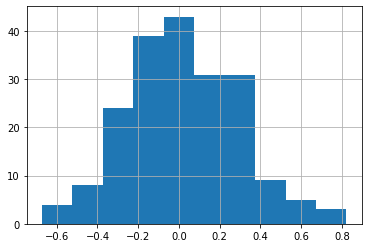

In [5]:
c_std.GAPDH_proteomics.hist()

cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: PT-Q2AG.N (/var/folders/7c/l09scrbj6bdgsg118sgq25wm0000gn/T/ipykernel_82809/2401899546.py, line 5)
/Applications/venv/CPTAC_Protein/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Applications/venv/CPTAC_Protein/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


<AxesSubplot:>

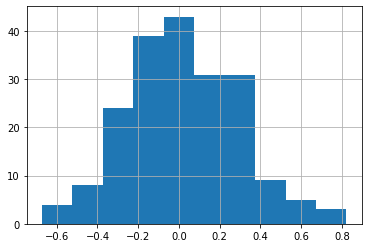

In [6]:
cptac.download(dataset="gbm")
gb = cptac.Gbm()
gb_rna = gb.get_transcriptomics()
gb_pro = gb.get_proteomics()
g = gb.join_omics_to_omics('transcriptomics', 'proteomics')
g.columns = g.columns.droplevel(1)
g_std = g.copy()
g_std = g_std.loc[:, ~g_std.columns.duplicated(keep='first')]
g_tx_cols = [col for col in g_std.columns if col.endswith('transcriptomics')]
g_std[g_tx_cols] = np.log2(g_std[g_tx_cols])
g_std[np.isinf(g_std)] = np.nan
g_std[g_tx_cols] = RobustScaler().fit_transform(g_std[g_tx_cols])
g_std.index = 'GB' + g_std.index

<AxesSubplot:>

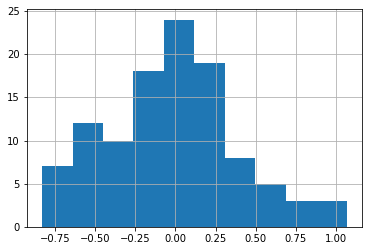

In [8]:
g.GAPDH_proteomics.hist()

Patient_ID
GBC3L-00104   -0.093902
GBC3L-00365   -0.119562
GBC3L-00674    0.074807
GBC3L-00677   -0.714060
GBC3L-01040   -0.114742
                 ...   
GBPT-RN5K.N    0.351135
GBPT-RU72.N    0.370103
GBPT-UTHO.N    0.257347
GBPT-WVLH.N    0.209840
GBPT-Y8DK.N    0.082089
Name: GAPDH_proteomics, Length: 109, dtype: float64

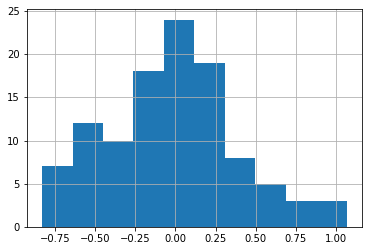

In [10]:
g_std.GAPDH_proteomics.hist()
g_std.GAPDH_proteomics